<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/transcription_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Model Text Error Correction

This notebook contains code that corrects the output of a handwriting
recognition model using techniques from neural machine translation. We
implement a basic encoder/decoder architecture with a transformer to
correct the output.

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa

# Python
import os

# Data Structures
import pandas as pd
import numpy as np

# Image/Plotting
from matplotlib import pyplot as plt

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode='Verbose', color_scheme='LightBg', tb_offset=1)

Download the Dataset from Google Drive

In [33]:
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1w0sumZm2YPxgMAsz9utAm9t2HriIe-JL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1w0sumZm2YPxgMAsz9utAm9t2HriIe-JL" -O error.csv && rm -rf /tmp/cookies.txt

In [3]:
# ID: 1liD_6fJvmRaQW4SjB3FPtfgd1vHrwxMN
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1liD_6fJvmRaQW4SjB3FPtfgd1vHrwxMN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1liD_6fJvmRaQW4SjB3FPtfgd1vHrwxMN" -O rimes.zip && rm -rf /tmp/cookies.txt
!unzip -q rimes.zip

In [3]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [4]:
CHAR_SET = {'char_to_idx': {'Ĵ': '318', '¬': '1', 'Õ': '2', 'Y': '3', 'Į': '4', 'ø': '5', 'Ÿ': '6', ',': '7', '«': '8', 'ĳ': '9', 'e': '10', 'Ô': '11', 'U': '12', '[': '13', 'j': '14', 'Ũ': '15', '3': '16', 'o': '17', 'ï': '18', 'd': '19', 'x': '20', 'ċ': '21', 'Ü': '22', 'ı': '23', 'Ð': '24', 'Ď': '25', 'Ŋ': '26', '2': '27', '®': '28', '9': '29', 'ß': '30', 'ľ': '31', '/': '32', 'V': '33', '½': '34', 'û': '35', 'h': '36', 'ě': '37', 'r': '38', 'm': '39', '¥': '40', 'g': '41', 'ĺ': '42', 'B': '43', 'Ė': '44', 'Ř': '45', 'Ĺ': '46', 'Ò': '47', 'ĥ': '48', 'À': '49', '{': '50', 'Ž': '51', 'ã': '52', ':': '53', 'Ì': '54', 'Ī': '55', 'Ķ': '56', 'ń': '57', 'õ': '58', 'Å': '59', 'G': '60', 'È': '61', 'ſ': '62', 'Ą': '63', '5': '64', 'ë': '65', 'Ō': '66', 'ŋ': '67', 'ţ': '68', 'Ħ': '69', 'Q': '70', 'č': '71', 'Ŀ': '72', '=': '73', 'Ĉ': '74', 'Ş': '75', 'Ū': '76', 'ħ': '77', 'ŗ': '78', 'É': '79', '%': '80', 'ť': '81', 'æ': '82', '±': '83', '?': '84', 'D': '85', '»': '86', 'ż': '87', 'ć': '88', '<': '89', '|': '90', 'C': '91', 'Ġ': '92', '´': '93', 'ŏ': '94', '.': '95', '$': '96', 'ü': '97', '+': '98', 'ġ': '99', 'Ï': '100', 'ŕ': '101', 'Ă': '102', 'i': '103', 'Ý': '104', '"': '105', 'w': '106', 'Ù': '107', 'Ŝ': '108', 'Đ': '109', 'Ä': '110', 'ì': '111', '`': '112', 'ű': '113', '\xad': '114', 'ģ': '115', 'î': '116', '7': '117', 'Ö': '118', 'İ': '119', 'ĵ': '120', 'Z': '121', '¶': '122', 'Ņ': '123', '¨': '124', '4': '125', 'R': '126', ']': '127', '^': '128', 'F': '129', 'ļ': '130', 'ğ': '131', 'k': '132', 'ī': '133', 'é': '134', 'ŉ': '135', 'Ń': '136', 'Ľ': '137', '!': '138', 'ù': '139', 'Ĳ': '140', 'S': '141', 'E': '142', 'â': '143', ')': '144', '·': '145', '¾': '146', 'Þ': '147', 'Ł': '148', 'ř': '149', 'Ļ': '150', 'Ê': '151', 'ä': '152', 'n': '153', 'œ': '154', '(': '155', 'ĕ': '156', '§': '157', 'ê': '158', '°': '159', 'ý': '160', '@': '161', 'Ź': '162', '-': '163', 'Ţ': '164', 'ũ': '165', 'ė': '166', '0': '167', 'Ĩ': '168', 'ş': '169', 'š': '170', 'ō': '171', 'ą': '172', 'H': '173', 'ų': '174', 'O': '175', 'ŭ': '176', ' ': '177', 'ñ': '178', 'ś': '179', 'b': '180', '¦': '181', 'Ú': '182', 'Œ': '183', 'ª': '184', 'ĩ': '185', 'W': '186', 'M': '187', 'ă': '188', 'ö': '189', 'ž': '190', 'ò': '191', 'µ': '192', 'f': '193', 'ň': '194', 'þ': '195', '1': '196', 'Ç': '197', 'Ć': '198', '¹': '199', 'Ŗ': '200', 'á': '201', 'c': '202', '>': '203', '8': '204', 'ł': '205', 'Š': '206', 'ő': '207', 'Ģ': '208', 'ŷ': '209', 'Ĕ': '210', 'Ś': '211', 'ŝ': '212', 'ź': '213', 'Â': '214', 'ĭ': '215', '³': '216', 'Ċ': '217', 'Ã': '218', 'į': '219', 'l': '220', 'Û': '221', 'Ĭ': '222', 'Ŧ': '223', 'Ż': '224', 'K': '225', 'N': '226', '¡': '227', '_': '228', 'å': '229', '£': '230', 'ū': '231', 'Ų': '232', '×': '233', 'Ā': '234', 'u': '235', 'ů': '236', 'Ě': '237', '*': '238', 'v': '239', 'T': '240', 'Ŕ': '241', 'ē': '242', 'A': '243', 'X': '244', '¼': '245', 'q': '246', '¤': '247', 's': '248', 'Ű': '249', 't': '250', 'Ŷ': '251', 'Č': '252', 'ĝ': '253', '\\': '254', 'Ů': '255', '#': '256', "'": '257', 'Á': '258', '¿': '259', '}': '260', 'y': '261', 'Ē': '262', 'Ŭ': '263', 'Ë': '264', '~': '265', 'Ę': '266', 'Ŵ': '267', 'Æ': '268', 'ð': '269', 'º': '270', 'Ó': '271', 'ā': '272', 'ô': '273', 'J': '274', 'ÿ': '275', 'ó': '276', 'Ĝ': '277', '&': '278', 'P': '279', '©': '280', 'Ğ': '281', 'è': '282', 'ę': '283', 'ĸ': '284', '²': '285', 'Ĥ': '286', '¢': '287', 'ŵ': '288', 'Î': '289', 'đ': '290', 'Í': '291', 'a': '292', ';': '293', 'à': '294', '¯': '295', '¸': '296', 'ņ': '297', 'L': '298', 'Ő': '299', 'ķ': '300', 'p': '301', 'Ŏ': '302', 'í': '303', 'ŧ': '304', 'ç': '305', 'Ť': '306', 'ŀ': '307', 'z': '308', 'ď': '309', 'Ň': '310', '6': '311', 'I': '312', '÷': '313', 'ú': '314', 'Ø': '315', 'Ñ': '316', 'ĉ': '317'},
            'idx_to_char': {'318': 'Ĵ', '1': '¬', '2': 'Õ', '3': 'Y', '4': 'Į', '5': 'ø', '6': 'Ÿ', '7': ',', '8': '«', '9': 'ĳ', '10': 'e', '11': 'Ô', '12': 'U', '13': '[', '14': 'j', '15': 'Ũ', '16': '3', '17': 'o', '18': 'ï', '19': 'd', '20': 'x', '21': 'ċ', '22': 'Ü', '23': 'ı', '24': 'Ð', '25': 'Ď', '26': 'Ŋ', '27': '2', '28': '®', '29': '9', '30': 'ß', '31': 'ľ', '32': '/', '33': 'V', '34': '½', '35': 'û', '36': 'h', '37': 'ě', '38': 'r', '39': 'm', '40': '¥', '41': 'g', '42': 'ĺ', '43': 'B', '44': 'Ė', '45': 'Ř', '46': 'Ĺ', '47': 'Ò', '48': 'ĥ', '49': 'À', '50': '{', '51': 'Ž', '52': 'ã', '53': ':', '54': 'Ì', '55': 'Ī', '56': 'Ķ', '57': 'ń', '58': 'õ', '59': 'Å', '60': 'G', '61': 'È', '62': 'ſ', '63': 'Ą', '64': '5', '65': 'ë', '66': 'Ō', '67': 'ŋ', '68': 'ţ', '69': 'Ħ', '70': 'Q', '71': 'č', '72': 'Ŀ', '73': '=', '74': 'Ĉ', '75': 'Ş', '76': 'Ū', '77': 'ħ', '78': 'ŗ', '79': 'É', '80': '%', '81': 'ť', '82': 'æ', '83': '±', '84': '?', '85': 'D', '86': '»', '87': 'ż', '88': 'ć', '89': '<', '90': '|', '91': 'C', '92': 'Ġ', '93': '´', '94': 'ŏ', '95': '.', '96': '$', '97': 'ü', '98': '+', '99': 'ġ', '100': 'Ï', '101': 'ŕ', '102': 'Ă', '103': 'i', '104': 'Ý', '105': '"', '106': 'w', '107': 'Ù', '108': 'Ŝ', '109': 'Đ', '110': 'Ä', '111': 'ì', '112': '`', '113': 'ű', '114': '\xad', '115': 'ģ', '116': 'î', '117': '7', '118': 'Ö', '119': 'İ', '120': 'ĵ', '121': 'Z', '122': '¶', '123': 'Ņ', '124': '¨', '125': '4', '126': 'R', '127': ']', '128': '^', '129': 'F', '130': 'ļ', '131': 'ğ', '132': 'k', '133': 'ī', '134': 'é', '135': 'ŉ', '136': 'Ń', '137': 'Ľ', '138': '!', '139': 'ù', '140': 'Ĳ', '141': 'S', '142': 'E', '143': 'â', '144': ')', '145': '·', '146': '¾', '147': 'Þ', '148': 'Ł', '149': 'ř', '150': 'Ļ', '151': 'Ê', '152': 'ä', '153': 'n', '154': 'œ', '155': '(', '156': 'ĕ', '157': '§', '158': 'ê', '159': '°', '160': 'ý', '161': '@', '162': 'Ź', '163': '-', '164': 'Ţ', '165': 'ũ', '166': 'ė', '167': '0', '168': 'Ĩ', '169': 'ş', '170': 'š', '171': 'ō', '172': 'ą', '173': 'H', '174': 'ų', '175': 'O', '176': 'ŭ', '177': ' ', '178': 'ñ', '179': 'ś', '180': 'b', '181': '¦', '182': 'Ú', '183': 'Œ', '184': 'ª', '185': 'ĩ', '186': 'W', '187': 'M', '188': 'ă', '189': 'ö', '190': 'ž', '191': 'ò', '192': 'µ', '193': 'f', '194': 'ň', '195': 'þ', '196': '1', '197': 'Ç', '198': 'Ć', '199': '¹', '200': 'Ŗ', '201': 'á', '202': 'c', '203': '>', '204': '8', '205': 'ł', '206': 'Š', '207': 'ő', '208': 'Ģ', '209': 'ŷ', '210': 'Ĕ', '211': 'Ś', '212': 'ŝ', '213': 'ź', '214': 'Â', '215': 'ĭ', '216': '³', '217': 'Ċ', '218': 'Ã', '219': 'į', '220': 'l', '221': 'Û', '222': 'Ĭ', '223': 'Ŧ', '224': 'Ż', '225': 'K', '226': 'N', '227': '¡', '228': '_', '229': 'å', '230': '£', '231': 'ū', '232': 'Ų', '233': '×', '234': 'Ā', '235': 'u', '236': 'ů', '237': 'Ě', '238': '*', '239': 'v', '240': 'T', '241': 'Ŕ', '242': 'ē', '243': 'A', '244': 'X', '245': '¼', '246': 'q', '247': '¤', '248': 's', '249': 'Ű', '250': 't', '251': 'Ŷ', '252': 'Č', '253': 'ĝ', '254': '\\', '255': 'Ů', '256': '#', '257': "'", '258': 'Á', '259': '¿', '260': '}', '261': 'y', '262': 'Ē', '263': 'Ŭ', '264': 'Ë', '265': '~', '266': 'Ę', '267': 'Ŵ', '268': 'Æ', '269': 'ð', '270': 'º', '271': 'Ó', '272': 'ā', '273': 'ô', '274': 'J', '275': 'ÿ', '276': 'ó', '277': 'Ĝ', '278': '&', '279': 'P', '280': '©', '281': 'Ğ', '282': 'è', '283': 'ę', '284': 'ĸ', '285': '²', '286': 'Ĥ', '287': '¢', '288': 'ŵ', '289': 'Î', '290': 'đ', '291': 'Í', '292': 'a', '293': ';', '294': 'à', '295': '¯', '296': '¸', '297': 'ņ', '298': 'L', '299': 'Ő', '300': 'ķ', '301': 'p', '302': 'Ŏ', '303': 'í', '304': 'ŧ', '305': 'ç', '306': 'Ť', '307': 'ŀ', '308': 'z', '309': 'ď', '310': 'Ň', '311': '6', '312': 'I', '313': '÷', '314': 'ú', '315': 'Ø', '316': 'Ñ', '317': 'ĉ'}
           }

class CharsetMapper:
  def __init__(self, max_sequence_size=128, start=319, end=320):
    self.max_sequence_size = max_sequence_size
    self.start = start
    self.end = end

  @staticmethod
  def remove_duplicates(idxs):
    new_idxs = []

    for i in range(len(idxs)):
        # Only append if the next character in the sequence is not
        # identical to the current character. If we're at the end of
        # the sequence, add it.
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])

    return new_idxs

  def idx_to_char(self, idx):
    if idx in [self.start, self.end]:
        return ''  # Return empty string for the blank character
    else:
      try:
        return CHAR_SET['idx_to_char'][str(int(idx))]
      except KeyError:
        return ''

  def char_to_idx(self, char):
      return int(CHAR_SET['char_to_idx'][char])

  def str_to_idxs(self, string):
    idxs = [self.start]

    for char in string:
      try:
        idxs.append(self.char_to_idx(char))
      except:
        continue
    
    idxs.append(self.end)

    # Pad the array to the max sequence size
    return idxs

  def idxs_to_str(self, idxs, remove_duplicates=True):
    string = ''

    if remove_duplicates:
      idxs = CharsetMapper.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)

    return string

  def str_to_idxs_batch(self, batch):
    idxs = []

    for string in batch:
      idx = self.str_to_idxs(string)
      idxs.append(idx)

    return idxs

  def idxs_to_str_batch(self, batch, remove_duplicates=True):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs, remove_duplicates=remove_duplicates))

    return strings

  def get_vocab_size(self):
    return len(CHAR_SET['char_to_idx']) + 1

In [5]:
class ErrorSequence(tf.keras.utils.Sequence):
  def __init__(self, path='/content/error.csv'):
    self.df = pd.read_csv(path, header=None, sep='\t', names=['original', 'error'])
    self.charset_mapper = CharsetMapper()
  
  def __getitem__(self, index):
    x = self.charset_mapper.str_to_idxs(str(self.df['error'][index]))
    x = tf.keras.preprocessing.sequence.pad_sequences([x], maxlen=128, padding='post')[0]
    y = self.charset_mapper.str_to_idxs(str(self.df['original'][index]))
    y = tf.keras.preprocessing.sequence.pad_sequences([y], maxlen=128, padding='post')[0]

    return tf.constant(x, dtype=tf.int64), tf.constant(y, dtype=tf.int64)
  
  def __len__(self):
    return len(self.df)

In [6]:
sequence = ErrorSequence()
mapper = CharsetMapper()
x, y = sequence[4]

print('error idx:', x.numpy())
print('error:', mapper.idxs_to_str(x.numpy()))
print('corrected idx:', y.shape)
print('corrected:', mapper.idxs_to_str(y.numpy()))

error idx: [319 142 244 248 250  10 177 292 220 193 292  38  38 201 180 103  17   7
 177 153  52 124  17 177  17 177  19  10 239  17  17 177 292  17 177  39
  10 235 177 239  10 220  36  49 177 202  38  17 153 103 248 248 250 292
 177  19  17 177 279 292 248 248 248  10 103  17 261 177 279 314 180 274
 103 202  17  95 177 177  79   7 177 202  17  39  17 177 248  10 177  19
 103 248 248  10 177 153  17 320   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
error: EXste alfarábio, nã¨o o devo ao meu velhÀ cronista do Paseioy PúbJico. É, como se dise no
corrected idx: (128,)
corrected: Este alfarábio, não o devo ao meu velho cronista do Paseio Público. É, como se dise no


In [7]:
def create_tfrecord_from_sequence(sequence, tfrecord_path):
    """
    Create a TfRecord dataset from a sequence

    :param sequence: The Keras sequence to load dataasdfs of arbitrary format
    :param tfrecord_path: Filepath and name for location of TfRecord dataset
    """
    print('Started creating TFRecord Dataset...')

    writer = tf.io.TFRecordWriter(tfrecord_path)

    for index, (img, label) in enumerate(sequence):
        feature = {'label': _bytes_feature(tf.io.serialize_tensor(label)),
                   'image': _bytes_feature(tf.io.serialize_tensor(img))}

        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())
        if index % 1000 == 0:
            print(str(index) + '/' + str(len(sequence)))

    print(str(len(sequence)) + '/' + str(len(sequence)))

    print('Finished: TFRecord created at', tfrecord_path)


def read_tfrecord(single_record):
    """
    Function to decode a TfRecord. Usually this function will be called within
    a TfDataset map function. Note that out_types for image and label must be
    tf.float32 and tf.int64 respectively.

    :param single_record: A single TfRecord
    :return: A decoded image and label as tensors
    """
    feature_description = {
        'label': tf.io.FixedLenFeature((), tf.string),
        'image': tf.io.FixedLenFeature((), tf.string)
    }

    single_record = tf.io.parse_single_example(single_record, feature_description)

    image = tf.io.parse_tensor(single_record['image'], out_type=tf.int64)
    label = tf.io.parse_tensor(single_record['label'], out_type=tf.int64)

    return image, label


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
create_tfrecord_from_sequence(ErrorSequence(), 'error.tfrecord')

In [103]:
class Train:
  def __init__(self):
    # Training
    self.EPOCHS = 10
    self.BATCH_SIZE = 128

    dataset_size = 100_000
    self.train_size = int(.8 * dataset_size)
    self.val_size = dataset_size - self.train_size
    self.dataset = tf.data.TFRecordDataset('error.tfrecord').map(read_tfrecord).shuffle(dataset_size)
    self.train_dataset = self.dataset.take(self.train_size).batch(self.BATCH_SIZE, drop_remainder=True)
    self.val_dataset = self.dataset.skip(self.val_size).take(self.val_size).batch(self.BATCH_SIZE, drop_remainder=True)

    # dataset = tf.data.experimental.CsvDataset('./labels.csv', [tf.string], field_delim='\t', use_quote_delim=False, select_cols=[1])\
                                              # .map(lambda src: tf.py_function(encode, [src], Tout=[tf.int32, tf.int32]))\
                                              # .batch(self.BATCH_SIZE)
    # self.dataset = tf.data.Dataset.from_tensor_slices(tf.ragged.constant(instances, dtype=tf.int32)).map(lambda sentence: tf.py_function(encode, [sentence], Tout=[tf.int32, tf.int32])).batch(self.BATCH_SIZE)                        

    self.encoder = Encoder(321, 256, 256, self.BATCH_SIZE)
    self.decoder = Decoder(321, 256, 256, self.BATCH_SIZE)

    self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.val_loss = tf.keras.metrics.Mean(name='val_loss')
  
  def train_step(self, src, trg, enc_hidden):
    loss = 0.0

    with tf.GradientTape() as tape:
      enc_output, enc_hidden = self.encoder(src, enc_hidden)
      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([319] * self.BATCH_SIZE, 1)

      # Teacher Forcing - feeding the target as the next input
      for t in range(1, trg.shape[1]):
        # Passing enc_output to the decoder
        predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
        loss += self.loss_function(trg[:, t], predictions)
        dec_input = tf.expand_dims(trg[:, t], 1)
      
      batch_loss = loss / int(trg.shape[1])
      variables = self.encoder.trainable_variables + self.decoder.trainable_variables
      gradients = tape.gradient(loss, variables)

      self.optimizer.apply_gradients(zip(gradients, variables))
    self.train_loss(batch_loss)

  def val_step(self, src, trg, enc_hidden):
    loss = 0.0
    enc_output, enc_hidden = self.encoder(src, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([319] * self.BATCH_SIZE, 1)

    # Teacher Forcing - feeding the target as the next input
    for t in range(1, trg.shape[1]):
      # Passing enc_output to the decoder
      predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
      loss += self.loss_function(trg[:, t], predictions)
      dec_input = tf.expand_dims(trg[:, t], 1)
    
    batch_loss = loss / int(trg.shape[1])
    self.val_loss(batch_loss)

  def loss_function(self, real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
  
  def __call__(self):
    for epoch in range(self.EPOCHS):
      self.train_loss.reset_states()
      enc_hidden = self.encoder.initialize_hidden_state()

      train_loop = tqdm(total=self.train_size//self.BATCH_SIZE, position=0, leave=True)
      for src, trg in self.train_dataset:
        self.train_step(src, trg, enc_hidden)
        train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}'.format(epoch, self.train_loss.result()))
        train_loop.update(1)
      train_loop.close()

      self.val_loss.reset_states()
      enc_hidden = self.encoder.initialize_hidden_state()

      val_loop = tqdm(total=self.val_size//self.BATCH_SIZE, position=0, leave=True)
      for src, trg, in self.val_dataset:
        self.val_step(src, trg, enc_hidden)
        val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}'.format(epoch, self.val_loss.result()))
        val_loop.update(1)
      val_loop.close()

In [104]:
train = Train()
train()

Val   - Epoch: 7, Loss: 0.1602:  44%|████▍     | 69/156 [01:10<01:24,  1.03it/s]

KeyboardInterrupt: ignored

In [105]:
def evaluate(sentence):
  attention_plot = np.zeros((128, 128))

  mapper = CharsetMapper()
  inputs = mapper.str_to_idxs(sentence)
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=128,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, 256))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([319], 0)

  for t in range(128):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += mapper.idx_to_char(predicted_id)

    if predicted_id == 320:
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [106]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [111]:
def translate(sentence, target):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  print('Target translation: {}'.format(target))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [108]:
import matplotlib.ticker as ticker

In [113]:
!tail error.csv

um do outro, ofegantes de canseira, mas remidos com a paga. Unem-se,	um0x ;outro, ofegantes de canstia, mas remidoos com a paga. Unem-se,
entrelaçam os braços, e regressam palpitando da inconsciência para a consciência.	entrelçam os braços,, e regrressam palpitandüo da inconsciência para a consciência.
"""Quem é esta que sobe do deserto, firmada sobre o seu amado?"", pergunta Sílvio,"	"""Quem é esta que sobex do deoserto, firmada sobre o ≠seu amado?"", pe4guunt Sílvio,"
"como no Cântico; e ela, com a mesma lábia erudita, responde-lhe que ""é o selo do"	"como no Cântico; e elάa, com a mmesma  lábia eruditaá resonde-lhe que ""é o selo do"
"seu coração"", e que ""o amor é tão valente como a própria morte""."	"seuucoração""‒ e que ""o amor é tão valente como a própria morte""J"
Nisto, o cônego estremece. O rosto ilumina-se-lhe. A pena, cheia de comoção e	Nisto,o cônego Üessstremece. OO rosto ilumina-se-lh⅗e. A pena, heîia de comooção e
respeito, completa o substantivo com o adjetivo. Sílvi

Input: entrelçam os braços,, e regrressam palpitandüo da inconsciência para a consciência.
Predicted translation: entrelçam os braços, e regrressam palpitando da inconsciência para a consciência para a consciência para a consciência para a co
Target translation: entrelaçam os braços, e regressam palpitando da inconsciência para a consciência.


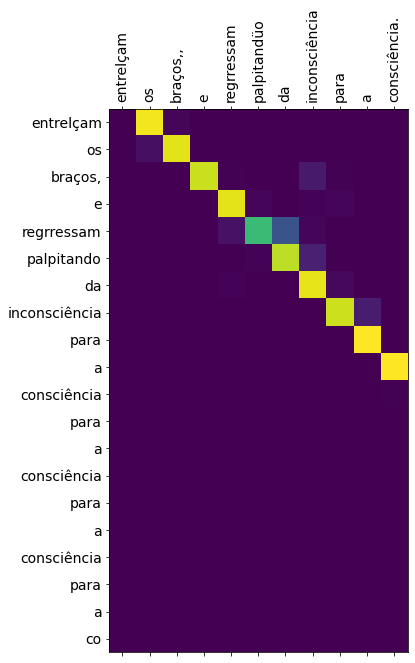

In [117]:
encoder = train.encoder
decoder = train.decoder

translate('entrelçam os braços,, e regrressam palpitandüo da inconsciência para a consciência.', 'entrelaçam os braços, e regressam palpitando da inconsciência para a consciência.')